In [145]:
import pandas as pd
import numpy as np
import scipy
from tqdm import trange
from tqdm.notebook import tqdm
import sys
import os
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from Sparse_vector import SparseVector


In [146]:
chroms = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y']]
#chroms = [f'chr1']#, 'chr2', 'chr3', 'chr4']

all_features = [i[:-4] for i in os.listdir('../data/omicDC_results/') if i.endswith('.pkl')]


In [147]:
import joblib
import pickle

In [148]:
print(chroms)

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY']


In [149]:
def chrom_reader(chrom):
    with (open(f"../data/dna_pkl/{chrom}.pkl", "rb")) as openfile:
        return pickle.load(openfile)

In [150]:
#print(all_features)

In [151]:
%%time
# load all the data
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chroms)}

DNA_features = {feature: joblib.load(f'../data/omicDC_results/{feature}.pkl') for feature in tqdm(all_features)}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/1948 [00:00<?, ?it/s]

CPU times: user 1min 27s, sys: 6.48 s, total: 1min 33s
Wall time: 1min 40s


In [152]:
#print(all_features)

In [153]:
ZDNA = joblib.load('../data/zdna/ZDNA.pkl')

In [154]:
#print((DNA_features['ATAC-Seq_ATAC-Seq']['chr1'][10000:20000]))


# All DL code

In [155]:
import torch
from torch.utils import data
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch.nn as nn

In [156]:
class Dataset(data.Dataset):
    def __init__(self, chroms, features, 
                 dna_source, features_source, 
                 labels_source, intervals):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        
    def __len__(self):
        return len(self.intervals)
    
    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))
        
        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        return (X, y)
        
        

In [162]:
width = 5000

np.random.seed(99)

ints_in = []
ints_out = []

for chrm in chroms:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in), replace=False)]

100%|██████████| 11445/11445 [00:00<00:00, 33345.45it/s]


In [163]:
equalized = np.vstack((ints_in, ints_out))
print(equalized)
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

[['chr1' '10000' '15000']
 ['chr1' '605000' '610000']
 ['chr1' '905000' '910000']
 ...
 ['chr13' '31190000' '31195000']
 ['chrY' '12030000' '12035000']
 ['chr10' '47095000' '47100000']]


In [164]:
train_inds, test_inds = next(StratifiedKFold().split(equalized, [f"{int(i < 400)}_{elem[0]}"
                                                                 for i, elem 
                                                                 in enumerate(equalized)]))

train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

train_dataset = Dataset(chroms, DNA_features.keys(), 
                       DNA, DNA_features, 
                       ZDNA, train_intervals)

test_dataset = Dataset(chroms, DNA_features.keys(), 
                       DNA, DNA_features, 
                       ZDNA, test_intervals)

In [165]:
#a = train_dataset[0][0]
#for i in a[0]:
    #print(i)
print(sum(test_dataset[1][1]))
print(len(test_dataset[1][1]))
#print(len(equalized))

57.0
5000


In [166]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

class DeepZ(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(1952, 500, 2, bidirectional=True)
        self.seq = nn.Sequential(
                    nn.Dropout(0.3),
                    nn.Linear(2 * 500, 500),
                    nn.Sigmoid(),
                    nn.Dropout(0.3),
                    nn.Linear(500, 2),
        )
    
    def forward(self, x):
        x, (h_n, c_n) = self.rnn(x)
        x = self.seq(x)
        return F.log_softmax(x, dim=-1)

In [167]:
bot_id = ''
bot_token = ''

from tqdm.contrib.telegram import tqdm as tqdm_telegram
import requests
import gc

def send_to_telegram(message):

    apiToken = bot_token
    chatID = bot_id
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'
    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
    except Exception as ex:
        print(ex)

In [168]:
#device = torch.device('cuda:1')

In [204]:
from sklearn.metrics import precision_recall_curve


params = {'batch_size':20,
          'num_workers':20,
          'shuffle':True}

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)
    
def loss_func(output, y_batch):
    #weight=torch.tensor([0.01, 0.99]).cuda()
    return torch.nn.NLLLoss(weight=torch.tensor([0.01, 0.99]).cuda())(torch.transpose(output, 2, 1), y_batch)


def train_epoch(model, optimizer, scheduler):
    loss_log, acc_log, roc_auc_log, f1_log = [], [], [], []
    model.train()
    TP, TN, FP, FN = 0, 0, 0, 0
    thresholds_per_batch = []

    for X_batch, y_batch in tqdm_telegram(loader_train, chat_id=bot_id, token=bot_token, mininterval=3):
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        optimizer.zero_grad()
        output = model(X_batch)
        
        y_pred = nn.Softmax(dim=1)(output)[:, :,1].detach()
        
        precision, recall, thresholds = precision_recall_curve(y_batch.cpu().flatten(), y_pred.cpu().flatten())
        numerator = 2 * recall * precision
        denom = recall + precision
        f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
        best_f1_score = np.max(f1_scores)
        best_threshold = thresholds[np.argmax(f1_scores)]
        
        thresholds_per_batch.append(best_threshold)
        
        pred = torch.where(y_pred > best_threshold, torch.Tensor([1]).cuda(), torch.Tensor([0]).cuda())
        
        y_pred = y_pred.detach().cpu().numpy().flatten()
        
        y_batch_cpu_numpy_flatten = y_batch.cpu().numpy().flatten()
        pred_cpu_numpy_flatten = pred.cpu().numpy().flatten()
        tn, fp, fn, tp = (
            y_batch[(y_batch == 0) & (pred == 0)].shape[0],
            y_batch[(y_batch == 0) & (pred == 1)].shape[0],
            y_batch[(y_batch == 1) & (pred == 0)].shape[0],
            y_batch[(y_batch == 1) & (pred == 1)].shape[0],
        )
        TN += tn
        FP += fp
        FN += fn
        TP += tp
        
        
        if np.std(y_batch_cpu_numpy_flatten) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y_batch_cpu_numpy_flatten,
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
        f1_log.append(f1_score(y_batch_cpu_numpy_flatten,
                         pred_cpu_numpy_flatten, zero_division=0))
        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    scheduler.step()
    print(f"Mean best train threshold: {np.mean(np.array(thresholds_per_batch))}")
    print(f"Last best train threshold: {thresholds_per_batch[-1]}")
    send_to_telegram(f"Mean best train threshold: {np.mean(np.array(thresholds_per_batch))}")
    send_to_telegram(f"Last best train threshold: {thresholds_per_batch[-1]}")
    
    return loss_log, acc_log, roc_auc_log, f1_log, TN, FP, FN, TP

def test(model):
    loss_log, acc_log, roc_auc_log, f1_log = [], [], [], []
    model.eval()
    means = []
    TP, TN, FP, FN = 0, 0, 0, 0
    thresholds_per_batch = []

    for X_batch, y_batch in tqdm_telegram(loader_test, chat_id=bot_id, token=bot_token, mininterval=3):
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        output = model(X_batch)
        means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
        
        
        y_pred = nn.Softmax(dim=1)(output)[:, :,1].detach()
        
        precision, recall, thresholds = precision_recall_curve(y_batch.cpu().flatten(), y_pred.cpu().flatten())
        numerator = 2 * recall * precision
        denom = recall + precision
        f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
        best_f1_score = np.max(f1_scores)
        best_threshold = thresholds[np.argmax(f1_scores)]
        
        thresholds_per_batch.append(best_threshold)
        
        pred = torch.where(y_pred > best_threshold, torch.Tensor([1]).cuda(), torch.Tensor([0]).cuda())
        
        y_pred = y_pred.detach().cpu().numpy().flatten()
        
        y_batch_cpu_numpy_flatten = y_batch.cpu().numpy().flatten()
        pred_cpu_numpy_flatten = pred.cpu().numpy().flatten()
        tn, fp, fn, tp = (
            y_batch[(y_batch == 0) & (pred == 0)].shape[0],
            y_batch[(y_batch == 0) & (pred == 1)].shape[0],
            y_batch[(y_batch == 1) & (pred == 0)].shape[0],
            y_batch[(y_batch == 1) & (pred == 1)].shape[0],
        )
        TN += tn
        FP += fp
        FN += fn
        TP += tp
        
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y_batch_cpu_numpy_flatten,
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
        f1_log.append(f1_score(y_batch_cpu_numpy_flatten,
                                  pred_cpu_numpy_flatten, zero_division=0))
        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss = loss.item()
        loss_log.append(loss)
    print(f"Mean best test threshold: {np.mean(np.array(thresholds_per_batch))}")
    print(f"Last best test threshold: {thresholds_per_batch[-1]}")
    send_to_telegram(f"Mean best test threshold: {np.mean(np.array(thresholds_per_batch))}")
    send_to_telegram(f"Last best test threshold: {thresholds_per_batch[-1]}")

    return loss_log, acc_log, roc_auc_log, f1_log, TN, FP, FN, TP


def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    epoch_num = len(valid_history)
    epoch_to_show = min(epoch_to_show, epoch_num)
    
    
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)    
    
    
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num + 1, (epoch_to_show + 1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs, scheduler, revision):
    train_log, train_acc_log, train_auc_log, train_f1_log = [], [], [], []
    val_log,   val_acc_log,   val_auc_log, val_f1_log   = [], [], [], []
    
    for epoch in tqdm_telegram(range(n_epochs), chat_id=bot_id, token=bot_token, mininterval=3):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        send_to_telegram("Epoch {} of {}".format(epoch + 1, n_epochs))
        
        train_loss, train_acc, train_auc, train_f1, TN, FP, FN, TP = train_epoch(model, opt, scheduler)
        send_to_telegram("Epoch {} train TN = {}, FP = {}, FN = {}, TP = {}".format(epoch+1, TN, FP, FN, TP))

        val_loss, val_acc, val_auc, val_f1, TN, FP, FN, TP = test(model)
        send_to_telegram("Epoch {} test TN = {}, FP = {}, FN = {}, TP = {}".format(epoch+1, TN, FP, FN, TP))
        
        BatchSize = len(train_loss)
        
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        train_auc_log.extend(train_auc)
        train_f1_log.extend(train_f1)

        val_log.append(np.mean(val_loss))
        val_acc_log.append(np.mean(val_acc))
        val_auc_log.append(np.mean(val_auc))
        val_f1_log.append(np.mean(val_f1))
#         raise BaseException
        
        if (epoch % 1) == 0:
            clear_output()
            plot_history(train_log,     val_log,     'Loss',     BatchSize)    
            plot_history(train_acc_log, val_acc_log, 'Accuracy', BatchSize)
            plot_history(train_auc_log, val_auc_log, 'Auc',      BatchSize)
            plot_history(train_f1_log,  val_f1_log,   'F1',       BatchSize)
            
            print("Epoch {} test AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
            print("Epoch {} train AUC = {:.2%}".format(epoch+1, np.mean(train_auc)))
            send_to_telegram("Epoch {} test AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
            send_to_telegram("Epoch {} train AUC = {:.2%}".format(epoch+1, np.mean(train_auc)))

            
            print("Epoch {} test accuracy = {:.2%}".format(epoch+1, val_acc_log[-1]))
            print("Epoch {} train accuracy = {:.2%}".format(epoch+1, np.mean(train_acc)))
            send_to_telegram("Epoch {} test accuracy = {:.2%}".format(epoch+1, val_acc_log[-1]))
            send_to_telegram("Epoch {} train accuracy = {:.2%}".format(epoch+1, np.mean(train_acc)))

            print("Epoch {} test f1 = {:.2%}".format(epoch+1, val_f1_log[-1]))
            print("Epoch {} train f1 = {:.2%}".format(epoch+1, np.mean(train_f1)))
            send_to_telegram("Epoch {} test f1 = {:.2%}".format(epoch+1, val_f1_log[-1]))
            send_to_telegram("Epoch {} train f1 = {:.2%}".format(epoch+1, np.mean(train_f1)))
            
            torch.save(model, f"model_rev{revision}_epoch_{epoch}.pt")
            gc.collect()
    print("Final AUC: {:.2}".format(val_auc_log[-1]))
    send_to_telegram("Final AUC: {:.2}".format(val_auc_log[-1]))


In [205]:
torch.cuda.empty_cache()

gc.collect()

747

In [206]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [207]:
model = DeepZ()
model = nn.DataParallel(model)
model = model.cuda()

print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 16325502


In [208]:
#print((ZDNA['chr1'][10000:11000]))

In [202]:
#print(DNA_features['TFs_and_others_ZNF432']['chrY'])

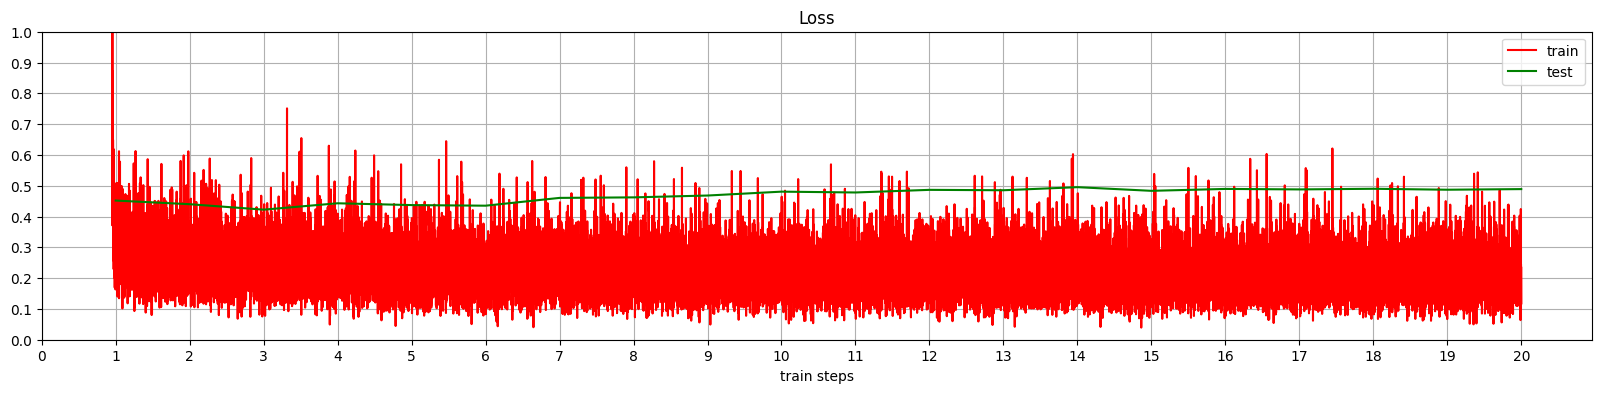

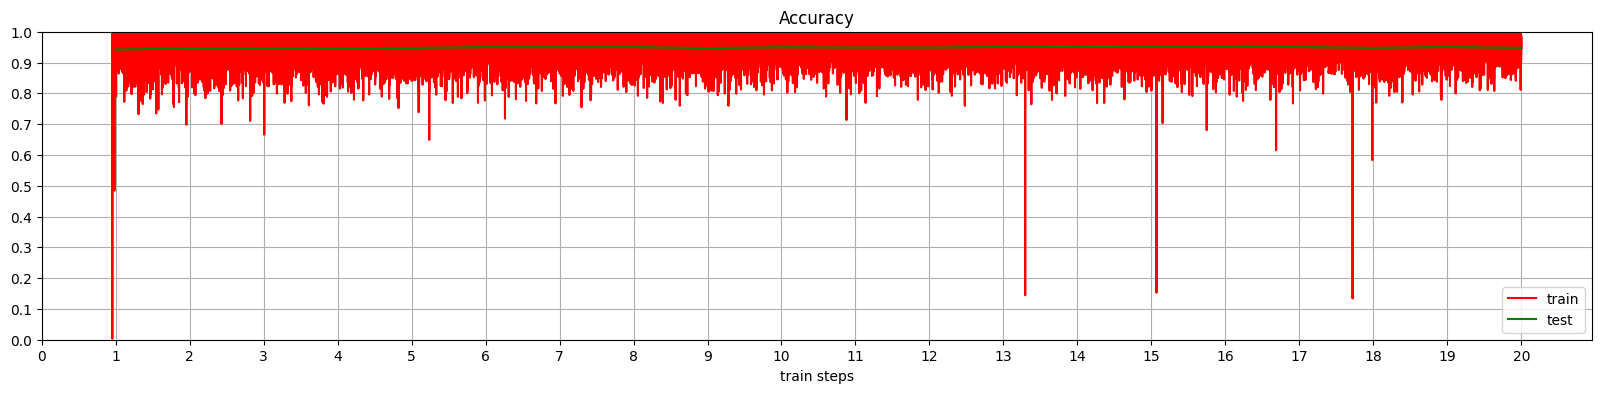

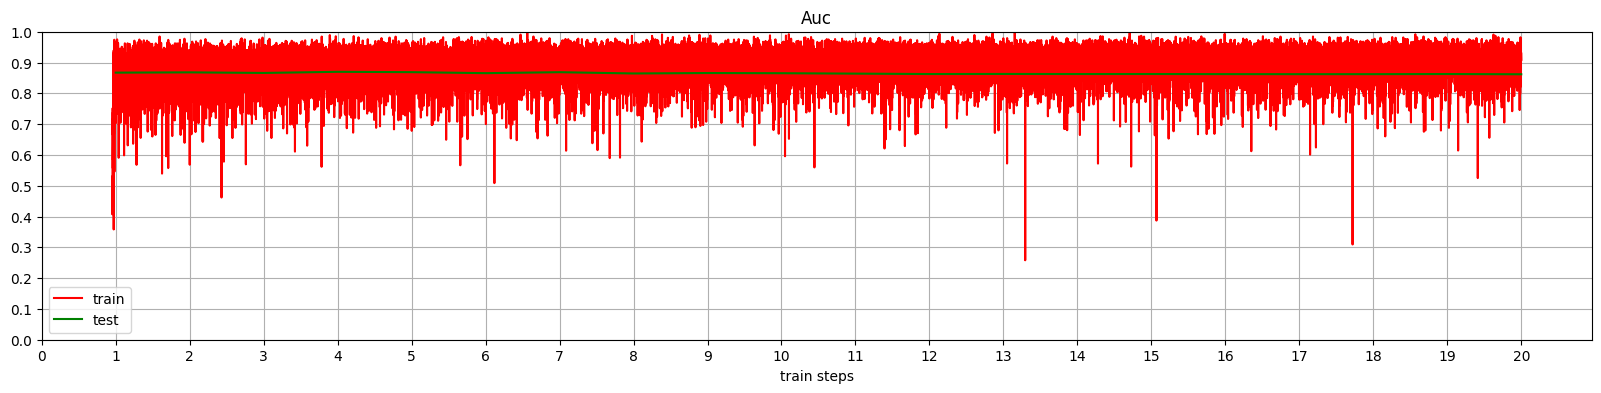

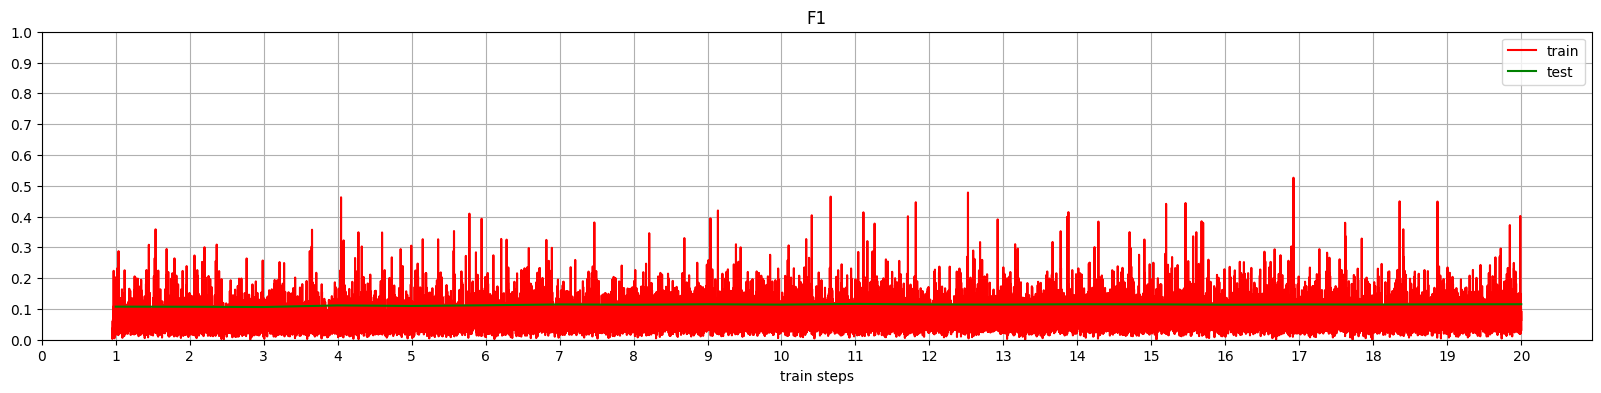

Epoch 20 test AUC = 86.19%
Epoch 20 train AUC = 90.14%
Epoch 20 test accuracy = 94.76%
Epoch 20 train accuracy = 95.67%
Epoch 20 test f1 = 11.52%
Epoch 20 train f1 = 7.39%
Final AUC: 0.86


In [209]:
REVISION = 27
opt = torch.optim.AdamW(model.parameters(), lr=10**-3, weight_decay=10**-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.7)
send_to_telegram(f"Started {REVISION} rev")
train(model, opt, 20, scheduler, REVISION)

In [49]:
for x,y in loader_test:
    break

In [52]:
model(x)
output = model(x)
pred = torch.argmax(output, dim=2)
y_pred = nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten()


In [57]:
y_pred.shape

(64000,)

In [58]:
y.flatten().shape

torch.Size([64000])

In [59]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y.flatten(), y_pred)

0.0011045735

In [73]:
y_pred = nn.Softmax(dim=1)(output)[:, :,1]

In [68]:
y_pred = nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy()

tensor(38686., device='cuda:0')

In [70]:
y.shape

torch.Size([64, 1000])

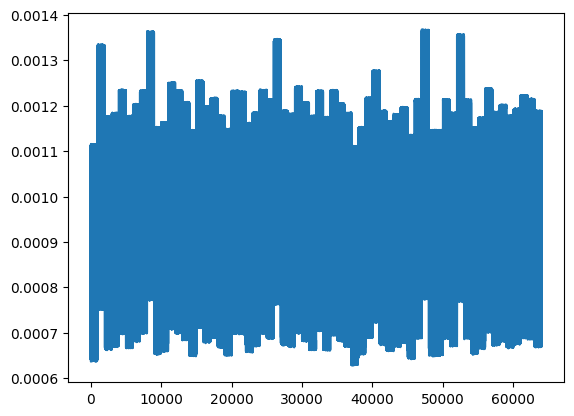

In [66]:
plt.plot(y_pred)

In [26]:
cnt_0, cnt_1 = 0, 0

for x, y in loader_test:
    
    
    cnt_1 += y.sum().item()
    cnt_0 += (y.shape[0] * y.shape[1] - y.sum().item())

In [27]:
cnt_1 / (cnt_1 + cnt_0), cnt_0 / (cnt_1 + cnt_0)

(0.008752535031847133, 0.9912474649681529)

In [71]:
cnt_0, cnt_1 = 0, 0

for x, y in loader_train:
    
    cnt_1 += y.sum().item()
    cnt_0 += (y.shape[0] * y.shape[1] - y.sum().item())

In [72]:
cnt_1 / (cnt_1 + cnt_0), cnt_0 / (cnt_1 + cnt_0)

(0.01813511811023622, 0.9818648818897637)